# Machine Learning on Graphs 

## Tools and library 

In this lab we start with the discovery of two popular libraries for analysing graphs, namely `scikit-network`, developped here at Télécom Paris,`networkx` and torch geometric. 

### Scikit-network

In [1]:
# Installation of the library 
# !pip install scikit-network

  Obtaining dependency information for scikit-network from https://files.pythonhosted.org/packages/a4/97/f81a16a39c699bfda977ba9b83b0e12a4cfc3d24aed47921720b3ae7dad5/scikit_network-0.31.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.7/954.7 kB 10.4 MB/s eta 0:00:0000:0100:01


In [1]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [2]:
import sknetwork
from sknetwork.data import load_netset, linear_graph
from sknetwork.ranking import PageRank, top_k
from sknetwork.visualization import svg_graph

#### Import data

Cora is a directed citation network of 2708 papers with link as citation (citing paper points to cited paper, the order in the edgelist is reversed). Each paper has one label (7 types of label in total). The labels are:

    Case Based
    Genetic Algorithms
    Neural Networks
    Probabilistic Methods
    Reinforcement Learning
    Rule Learning
    Theory

Also, each papers has a binary feature vector of 1433 elements (word existance indicator) describing the content of the node. The end of each feature vector is the string label of the paper (e.g. Case_Based, or Neural_Networks). All nodes has label and feature vector.


In [26]:
cora = load_netset('cora')

Parsing files...
Done.


In [27]:
# Let us take a closer look at the cora object
cora

{'labels': array([2, 2, 1, ..., 6, 6, 6]),
 'meta': {'name': 'Cora',
  'source': 'https://relational.fit.cvut.cz/dataset/CORA',
  'description': 'Graph of citations between scientific publications.',
  'long_description': 'Graph of citations between 2708 scientific publications on Machine Learning. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.',
  'date': '2008'},
 'biadjacency': <2708x1433 sparse matrix of type '<class 'numpy.bool_'>'
 	with 49216 stored elements in Compressed Sparse Row format>,
 'adjacency': <2708x2708 sparse matrix of type '<class 'numpy.bool_'>'
 	with 5429 stored elements in Compressed Sparse Row format>,
 'names': array([     35,      40,     114, ..., 1154524, 1154525, 1155073]),
 'names_labels': array(['Theory', 'Reinforcement Learning', 'Genetic Algorithms',
       

In [28]:
# We can then access to specific elements of the cora object as follow
lab = cora.labels
adj = cora.adjacency

**To do** : where are the node features ? 

In [29]:
features = cora.biadjacency

In [32]:
A = np.array([[0,1,1],[2,0,0],[0,1,0]])
A

array([[0, 1, 1],
       [2, 0, 0],
       [0, 1, 0]])

In [33]:
A_csr = sparse.csr_matrix(A)
A_csr.data, A_csr.indices, A_csr.indptr

(array([1, 1, 2, 1]),
 array([1, 2, 0, 1], dtype=int32),
 array([0, 2, 3, 4], dtype=int32))

In [35]:
i = 0
A_csr.indices[A_csr.indptr[i]:A_csr.indptr[i+1]] #à la ligne i=0, j'ai des valeur non nulles au colonnes...

array([1, 2], dtype=int32)

#### Description of the graph Cora

In [9]:
# Number of nodes and edges 
print("Number of nodes: ", adj.shape[0])
print("Number of links: ", adj.nnz)

Number of nodes:  2708
Number of links:  5429


**To do** : use the adjacency matrix to get the average out-degree.

In [36]:
adj.sum(axis=1)

matrix([[166],
        [  3],
        [ 42],
        ...,
        [  0],
        [  0],
        [  0]])

In [37]:
from sknetwork.utils import get_degrees

In [40]:
get_degrees(adj, transpose=False) #out
get_degrees(adj, transpose=True) #in

array([3, 1, 0, ..., 3, 3, 3], dtype=int32)

#### Visualization of the graph Cora

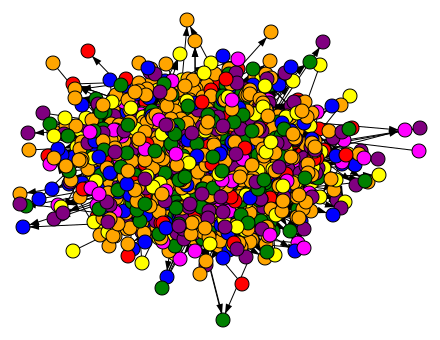

In [41]:
# Visualisation of the graph
image = svg_graph(adj, labels=lab)
SVG(image)

## Networkx

The second library is networkx. Documentation available [here](https://networkx.org/documentation/latest/).

In [42]:
# Installation of the library 
#!pip install networkx

In [43]:
import networkx as nx
import pandas as pd
import os

In [44]:
# Import the data 
# Compared to scikit-network, networkx does not allow to directly import some well-known graph

data_loc = 'cora/'  # 'cora.cites', 'cora.content'

edgelist = pd.read_csv(os.path.join(data_loc, "cora.cites"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"
    
# Let's take a quick look at the data 
edgelist.sample(frac=1).head(5)

,source,target,label
1252,6213,153598,cites
3516,66794,1105505,cites
5061,582343,1128437,cites
3388,58758,1128204,cites
2050,15987,158098,cites


In [45]:
# Convert the data to a directed graph
cora = nx.DiGraph()
cora.add_edges_from([(row.source, row.target) for _, row in edgelist.iterrows()])
nx.set_node_attributes(cora,  "paper", "label")

In [46]:
# We can also retrieve the node labels subject
cora_meta = os.path.expanduser(os.path.join(data_loc, "cora.content"))
node_attr = pd.read_csv(cora_meta, sep='\t', header=None)
values = { row.tolist()[0]: row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(cora, values, 'subject')

#### Ready to describe the network 

We will follow the same steps as for scikit-network to describe the graph. Le networkx library offers more straighforward functions to obtain these caracteristics. 

In [47]:
print("Number of nodes: ", cora.number_of_nodes())
print("Number of edges: ", cora.number_of_edges())

Number of nodes:  2708
Number of edges:  5429


In [48]:
# We can also compute the degree of each node 
outdeg_cora = cora.out_degree()
indeg_cora = cora.in_degree()
deg_cora = cora.degree()
type(deg_cora)

networkx.classes.reportviews.DiDegreeView

**To do**: check what is the type of deg_cora, then write a function to get the average degree of a graph 

In [ ]:
def average_degree(G):
    # to do
    G.out_degree().mean()
    return 

In [54]:
nx?

Type:        module
String form: <module 'networkx' from '/Users/salimatoutraore/opt/anaconda3/envs/mon_environnement/lib/python3.11/site-packages/networkx/__init__.py'>
File:        ~/opt/anaconda3/envs/mon_environnement/lib/python3.11/site-packages/networkx/__init__.py
Docstring:  
NetworkX

NetworkX is a Python package for the creation, manipulation, and study of the
structure, dynamics, and functions of complex networks.

See https://networkx.org for complete documentation.

In [65]:
# Centrality measures 

## eigenvectors 
c_eig = nx.eigenvector_centrality(cora)

## closeness 
c_clo = nx.closeness_centrality(cora)

## betweeness 
c_bet = nx.betweenness_centrality(cora)

**To do** For each centrality measure and degree get the top-5 most important nodes. What do you observe?

In [66]:
#eigenvector
eigenvector_top5 = sorted(((c, v) for v, c in c_eig.items()), reverse=True)[:5]

#closeness
closeness_top5 = sorted(((c, v) for v, c in c_clo.items()), reverse=True)[:5]

#betweeness
betweeness_top5 = sorted(((c, v) for v, c in c_bet.items()), reverse=True)[:5]

In [67]:
print(eigenvector_top5)
print(closeness_top5)
print(betweeness_top5)

[(0.48479965389796276, 126927), (0.392398543266169, 103543), (0.35919068751687344, 645897), (0.29153241542990344, 644093), (0.2852620291586931, 646286)]
[(0.007026311311082794, 1107067), (0.0068466561895399874, 1153811), (0.00683873495235103, 66982), (0.0067427527074057515, 39210), (0.0066922578607260825, 1050679)]
[(0.0013001113152482232, 1272), (0.0012246178981922806, 13686), (0.001166348265558083, 6184), (0.0009926087439670113, 85688), (0.000984276709812133, 887)]


## Node Embedding : DeepWalk

DeepWalk is a classic baseline for node embedding, based on random walks. Basically, a random walk is a way of converting a graph into a sequence of nodes. DeepWalk consists of two main steps: 
1. For each node in the graph, generate a random path of nodes connected 
2. From the corpus of random paths generated in step 1, train a skip-gram (Word2Vec) model 

In this part, we start by implementing the random walk ourselves (for understanding purpose), then use the Word2Vec implementation provided in `gensim`. Then, you will have to find a scalable implementation of the random-walk online and apply it to the full cora network (=what you'll have to do in companies !). 

In [68]:
import random

# Convert Cora to an undirected network 
cora_u = cora.to_undirected()

### Random walk 

Our objective is to write a function, that given a graph, a specific node and the length of the walk, generate a random walk on the graph. The ouput of the function is a list of all the nodes composing the walk. To obtain the list of direct neighbors of a given node, you can use the function `all_neighbors` from the `networkx` package.

In [84]:
import random 

walkLength = 10
startNode = list(cora_u.nodes)[0]

# Initialize the walk 
walk = [str(startNode)]
current_node = startNode
for _ in range(walkLength-1):
    # List of neighbors 
    neighbors = list(nx.all_neighbors(cora_u, current_node))
    # Select a random node as the next step in the walk 
    next_node = random.choice(neighbors)
    # Add the node to the walk 
    walk.append(str(next_node))
    # Update de position of the random walk 
    current_node = next_node

# Display the obtained walk
print(walk) 

['35', '141342', '1119708', '82920', '1152421', '14062', '646836', '503883', '646809', '35']


#### To do 

1. Define a function random_walk containing the steps above 
2. Explain the code given below. Then based on this latter, define a function RandomWalker that perform a given number of random walks per node and output a corpus of randomwalks (test with 2 random walks per node).

**To do** What do you observe if you run the above cell multiple times ? Why ?

In [91]:
def random_walk(g, node, wlen=10):
    # To do 
    walk = [str(node)]
    current_node = node
    for _ in range(wlen-1):
        # List of neighbors 
        neighbors = list(nx.all_neighbors(g, current_node))
        # Select a random node as the next step in the walk 
        next_node = random.choice(neighbors)
        # Add the node to the walk 
        walk.append(str(next_node))
        # Update de position of the random walk 
        current_node = next_node
    return walk

walks = []
for node in cora.nodes():
    for _ in range(30):
        walks.append(random_walk(cora, node))

pd.DataFrame(walks)

,0,1,2,3,4,5,6,7,8,9
0,35,1129573,12576,56119,127033,56115,69284,46079,35,593260
1,35,254923,108047,254923,415693,84021,1688,1131360,35,646837
2,1033,45605,240791,45605,1131639,390693,1131639,390693,1131639,45605
3,1033,1034,1026,1153945,1026,1102550,94641,1102550,1026,1153945
4,103482,27510,188318,1365,1031453,1365,340075,90888,3229,52515
...,...,...,...,...,...,...,...,...,...,...
5411,853155,853116,853115,853116,853114,853155,853116,853115,853114,853115
5412,853115,19621,684372,19621,62347,19621,649730,123825,649730,1131464
5413,853115,19621,49482,1112369,217984,49482,3229,90888,1113934,90888
5414,853118,853155,853114,853115,853116,19621,184918,19621,123825,23448


In [ ]:
""""
def RandomWalker(g, nb_walks, wlen=10):
    walks = []
    for node in g.nodes():
        for _ in range(nb_walks):
            walks.append(random_walk(g, node))

    pd.DataFrame(walks)
"""

### Word2Vec 



In [92]:
# Install the library 
#!pip install gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/99/f5/8d2cb0b2628bb6482baafbf0ff7262c11fc46e98b23ee79234828b927e8d/gensim-4.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/fc/d9/d97f1db64b09278aba64e8c81b5d322d436132df5741c518f3823824fae0/smart_open-6.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.2 MB/s eta 0:00:00


In [93]:
from gensim.models import Word2Vec

In [94]:
# Initialise the model 
embedder = Word2Vec(
    window = 3,
    seed=42,
    sg=1,
    vector_size=32,
    hs=0, 
    negative=10, 
    alpha=0.02, 
    min_alpha=0.0001,
)

**To do** : take a look at all the hyper-parameters and check for their meaning in the documentation. 
Write in comments their role in the cell above. 

In [96]:
# Next, we build the vocabulary out of the nodes 
embedder.build_vocab(walks,progress_per=2)
embedder.train(
    walks,
    total_examples=embedder.corpus_count, 
    epochs=4, 
)

vectors = pd.DataFrame({node: embedder.wv[node] for node in embedder.wv.key_to_index.keys()}).T

**To do** : display the shape of embedding matrix and the 3 first rows. 

In [103]:
print(vectors.shape)
vectors[:3]

(2646, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
35,0.262082,-0.182298,0.146984,0.291056,0.036232,-0.089090,0.170552,-0.070755,-0.118230,-0.371251,...,-0.881933,0.410971,0.221163,0.212557,0.019008,-0.553733,-0.114489,0.127028,-0.538562,-0.058976
1365,0.465166,-0.367418,0.714394,-0.556796,0.473728,0.157991,-0.218768,-0.425023,-0.468932,-0.530053,...,-0.817606,-0.559337,0.371867,-0.334087,-0.188856,-0.348867,-0.214355,0.593364,-0.133057,0.213440
3229,0.258310,-0.426683,0.487315,-0.189796,0.108672,-0.088929,0.101027,-0.324874,-0.340881,-0.451592,...,-0.927649,-0.090313,0.357033,-0.128701,-0.190428,-0.414640,-0.234481,0.443406,-0.044525,0.026532


In [104]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [105]:
# Join embedding and label information
t = pd.DataFrame.from_dict(values, orient='index', columns=['label'])
t.index = t.index.astype(str)
h = vectors.join(t, how='left')
print(h.shape)
h.head()

(2646, 33)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
35,0.262082,-0.182298,0.146984,0.291056,0.036232,-0.089090,0.170552,-0.070755,-0.118230,-0.371251,...,0.410971,0.221163,0.212557,0.019008,-0.553733,-0.114489,0.127028,-0.538562,-0.058976,Genetic_Algorithms
1365,0.465166,-0.367418,0.714394,-0.556796,0.473728,0.157991,-0.218768,-0.425023,-0.468932,-0.530053,...,-0.559337,0.371867,-0.334087,-0.188856,-0.348867,-0.214355,0.593364,-0.133057,0.213440,Neural_Networks
3229,0.258310,-0.426683,0.487315,-0.189796,0.108672,-0.088929,0.101027,-0.324874,-0.340881,-0.451592,...,-0.090313,0.357033,-0.128701,-0.190428,-0.414640,-0.234481,0.443406,-0.044525,0.026532,Neural_Networks
6213,0.534109,-0.430230,-0.134326,-0.138750,0.832537,0.090157,-0.044590,-0.833405,-0.082753,-0.512471,...,0.020976,0.402711,0.321839,0.122511,-0.384101,0.092773,0.542798,-0.601607,0.294262,Reinforcement_Learning
910,0.651478,-0.399862,0.364138,-0.148012,-0.189108,0.055135,0.066427,-0.313805,-0.221901,-0.738140,...,-0.286967,0.447275,-0.242990,-0.372025,-0.541089,-0.490109,0.474457,-0.115393,0.156708,Neural_Networks


In [106]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_vectors = tsne_model.fit_transform(h.iloc[:,:-1])

**To do** : check the dimension of tsne_vectors and take a look at the documentation of TSNE to explain the hyper-parameters.

In [109]:
tsne_vectors.shape
TSNE?

Init signature:
TSNE(
    n_components=2,
    *,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='euclidean',
    metric_params=None,
    init='pca',
    verbose=0,
    random_state=None,
    method='barnes_hut',
    angle=0.5,
    n_jobs=None,
)
Docstring:     
T-distributed Stochastic Neighbor Embedding.

t-SNE [1] is a tool to visualize high-dimensional data. It converts
similarities between data points to joint probabilities and tries
to minimize the Kullback-Leibler divergence between the joint
probabilities of the low-dimensional embedding and the
high-dimensional data. t-SNE has a cost function that is not convex,
i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimensions to a reasonable amount (e

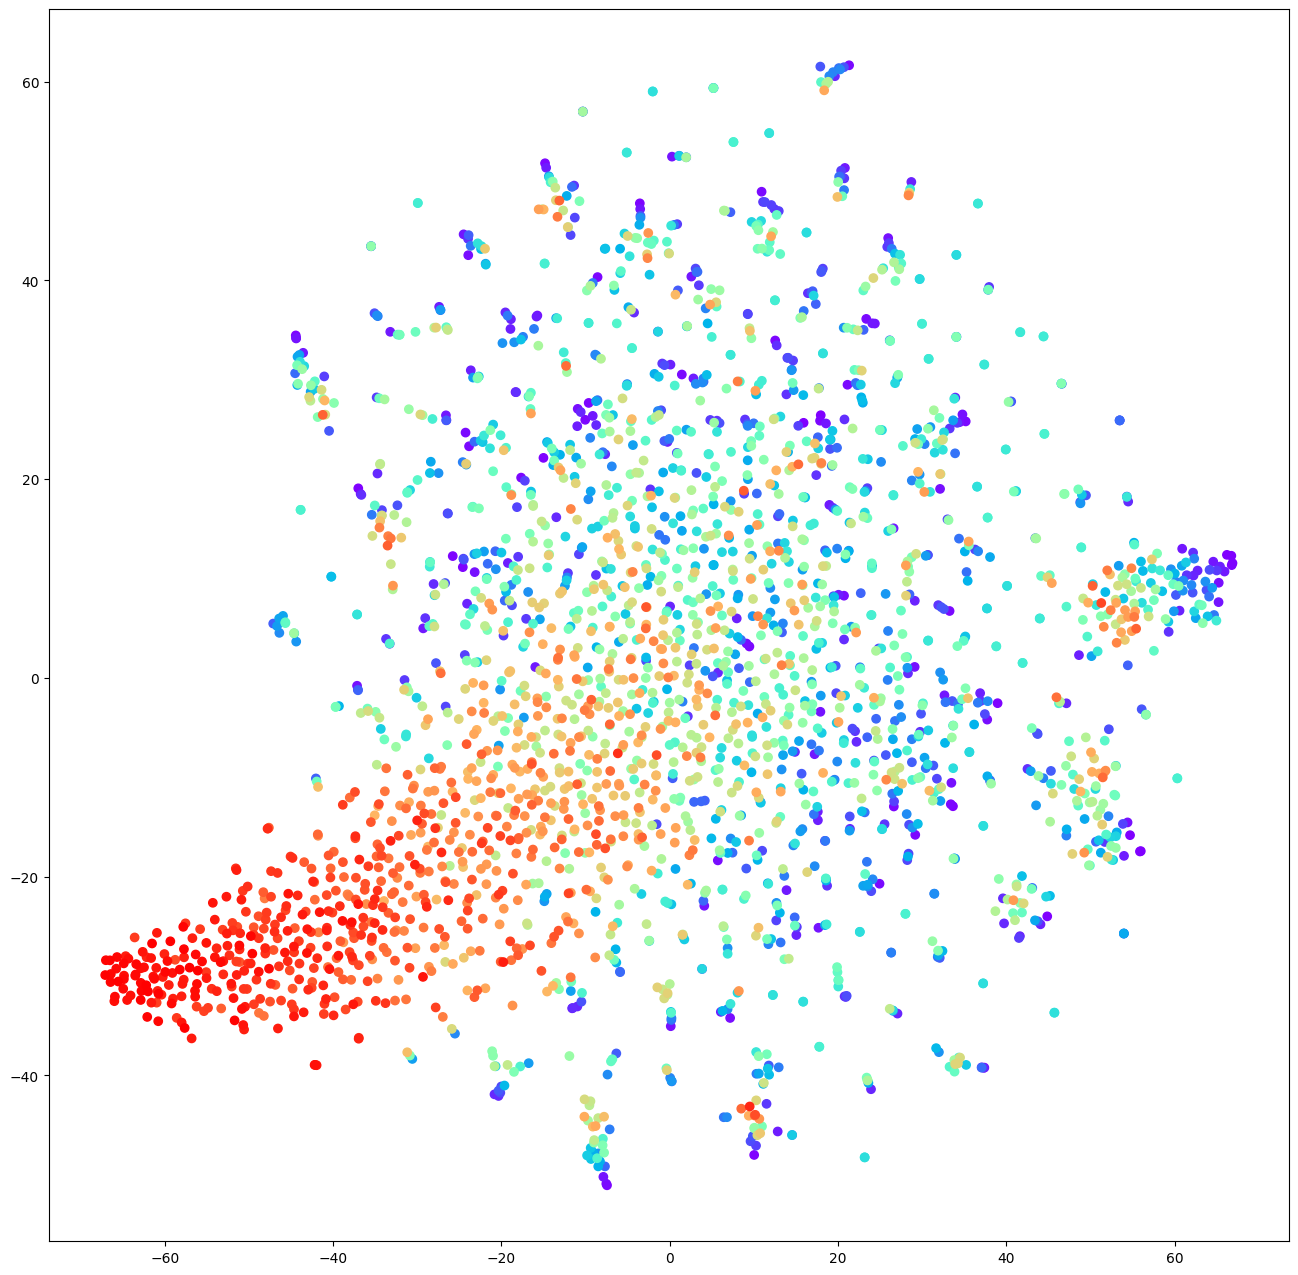

In [108]:
# Plot 
x = tsne_vectors[:,0]
y = tsne_vectors[:,1]

# Retrieve labels for visualisation 
labels = h.iloc[:,-1:]
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, label=labels, c=colors)
plt.show()

### To do 

1. Code improvement: define a class DeepWalk, which given a graph, the walk length, the number of walks per nodes and the desired dimension outputs the dataframe (or any object of your choice) of the embeddings. An option must allow to choose to visualize the obtained embedding with t-sne.

2. Use the obtained vectors as input data to learn a classifier (of your choice) to predict the **subject** of a paper. Note that, in our case we are only using the position of the paper in the graph and not the node features. 

3. Run Node2Vec on the same data and compare the obtained visualization and a classifier. You can choose the implementation/tool/librairy of your choice.